# Model Selection

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql3
import random

random.seed(1000)
np.random.seed(1000)

sns.set(style="darkgrid")
ROOT_PATH="C:/Users/moshe/Documents/projectML/p1"
DATA_PATH = "%s/data/raw" % ROOT_PATH
DB_FILE = "%s/hairsalon.db" % DATA_PATH
def readSQL(query):
    import pandas as pd
    import sqlite3 as sql3
    db = sql3.connect(DB_FILE)
    df = pd.read_sql_query(query, db)
    db.close()
    return(df)

db=sql3.connect(DB_FILE)

In [49]:
def readXy(query):
    df=readSQL(query)
    for c in df.columns:
        if df[c].nunique() < 14:
            df[c] = df[c].astype('category')
    df=df.reindex(np.random.permutation(df.index)).reset_index(drop=True)
    X=df.loc[:,df.columns[1:]]
    y=df['noshowflag']
    return X,y

query="""select * from rtest"""
Xtest,ytest=readXy(query)
query="""select * from rtrain"""
Xtrain,ytrain=readXy(query)
query="""select * from rdev"""
Xdev,ydev=readXy(query)
Xftrain=pd.concat([Xtrain,Xdev])
yftrain=pd.concat([ytrain,ydev])
print([len(Xtrain),len(Xdev),len(Xftrain)])
Xftrain=Xftrain.reset_index(drop=True)
yftrain=yftrain.reset_index(drop=True)
test_fold1=np.full(len(Xtrain),-1)
test_fold2=np.full(len(Xdev),0)
test_fold=np.append(test_fold1,test_fold2)

[1935, 484, 2419]


## Applying Lasso and Ridge Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression
modellasso = LogisticRegression(penalty='l1',random_state=10)
modellasso.fit(Xtrain,ytrain)

C:\Users\moshe\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=10, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [51]:
print("Accuracy - Train: %s, Dev: %s" % (modellasso.score(Xtrain,ytrain), modellasso.score(Xdev,ydev)))

Accuracy - Train: 0.8155038759689922, Dev: 0.8264462809917356


In [52]:
from sklearn.linear_model import LogisticRegression
modelridge = LogisticRegression(penalty='l2',random_state=10)
modelridge.fit(Xtrain,ytrain)

C:\Users\moshe\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=10, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [53]:
print("Accuracy - Train: %s, Dev: %s" % (modelridge.score(Xtrain,ytrain), modelridge.score(Xdev,ydev)))

Accuracy - Train: 0.81343669250646, Dev: 0.8202479338842975


## Applying Random Forest

In [54]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(random_state=10,n_estimators=100,max_depth=2)
rfmod = RandomForestClassifier().fit(Xtrain, ytrain)


C:\Users\moshe\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [55]:
print("Accuracy - Train: %s, Dev: %s" % (rfmod.score(Xtrain,ytrain), rfmod.score(Xdev,ydev)))

Accuracy - Train: 0.9963824289405685, Dev: 0.8987603305785123


## Applying XgB

In [56]:
import xgboost as xgb

classifier=xgb.XGBClassifier(random_state=100)
Xtrainnum=Xtrain.copy()
columnstoconvert=Xtrainnum.loc[:,Xtrainnum.dtypes=='category'].columns
Xtrainnum[columnstoconvert]=Xtrainnum[columnstoconvert].astype(int)
ytrainnum=ytrain.copy().astype(int)
xgbmod=classifier.fit(Xtrainnum,ytrainnum)
Xdevnum=Xdev.copy()
columnstoconvert=Xdevnum.loc[:,Xdevnum.dtypes=='category'].columns
Xdevnum[columnstoconvert]=Xdevnum[columnstoconvert].astype(int)
ydevnum=ydev.copy().astype(int)
ypred=xgbmod.predict(Xdevnum)

In [57]:
from sklearn.metrics import accuracy_score

print("Accuracy - Train: %s, Dev: %s" % (accuracy_score(ytrainnum,xgbmod.predict(Xtrainnum))
                                        ,accuracy_score(ydevnum,ypred)))

Accuracy - Train: 0.8837209302325582, Dev: 0.8409090909090909


## Applying SVM Classifier

In [58]:
from sklearn.svm import SVC
svmmod = SVC(C=0.01,gamma='auto',probability=True,random_state=100).fit(Xtrain, ytrain)

In [59]:
print("Accuracy - Train: %s, Dev: %s" % (svmmod.score(Xtrain,ytrain), svmmod.score(Xdev,ydev)))

Accuracy - Train: 0.5069767441860465, Dev: 0.49793388429752067


## Applying Adaboost

In [60]:
from sklearn.ensemble import AdaBoostClassifier
adamod=AdaBoostClassifier(random_state=1000).fit(Xtrain,ytrain)


In [61]:
print("Accuracy - Train: %s, Dev: %s" % (adamod.score(Xtrain,ytrain), adamod.score(Xdev,ydev)))

Accuracy - Train: 0.8444444444444444, Dev: 0.8264462809917356


## Applying GradientBoosting

In [62]:
from sklearn.ensemble import GradientBoostingClassifier
gbmod = GradientBoostingClassifier(random_state=1000).fit(Xtrain, ytrain)


In [63]:
print("Accuracy - Train: %s, Dev: %s" % (gbmod.score(Xtrain,ytrain), gbmod.score(Xdev,ydev)))

Accuracy - Train: 0.903359173126615, Dev: 0.8698347107438017


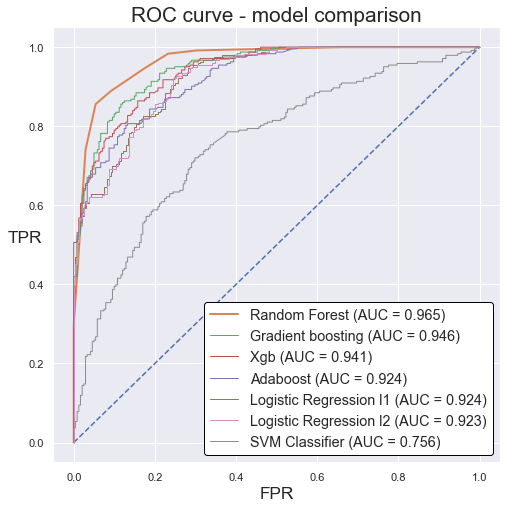

In [64]:
from sklearn.metrics import roc_curve, auc
pred1 = modellasso.predict_proba(Xdev)
fpr1, tpr1, thresholds = roc_curve(ydev.values, pred1[:,1],pos_label='1')

pred2 = modelridge.predict_proba(Xdev)
fpr2, tpr2, thresholds = roc_curve(ydev.values, pred2[:,1],pos_label='1')

#random forest
pred3=rfmod.predict_proba(Xdev)
fpr3, tpr3, thresholds = roc_curve(ydev.values, pred3[:,1],pos_label='1')

#xgb
pred4=xgbmod.predict_proba(Xdevnum)
fpr4, tpr4, thresholds = roc_curve(ydevnum.values, pred4[:,1],pos_label=1)

#SVM
pred5=svmmod.predict_proba(Xdevnum)
fpr5, tpr5, thresholds = roc_curve(ydev.values, pred5[:,1],pos_label='1')

#adaboost
pred6=adamod.predict_proba(Xdevnum)
fpr6, tpr6, thresholds = roc_curve(ydev.values, pred6[:,1],pos_label='1')

#gradient boosting
pred7=gbmod.predict_proba(Xdevnum)
fpr7, tpr7, thresholds = roc_curve(ydev.values, pred7[:,1],pos_label='1')


import matplotlib.pyplot as plt
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
roc_auc5 = auc(fpr5, tpr5)
roc_auc6 = auc(fpr6, tpr6)
roc_auc7 = auc(fpr7, tpr7)


x=np.linspace(0,1)
y=x

fig, ax = plt.subplots(figsize=(8, 8))


plt.title("ROC curve - model comparison",fontsize='xx-large')
plt.xlabel("FPR",fontsize='x-large')
plt.ylabel("TPR",rotation=0,fontsize='x-large')
plt.plot(x,y,linestyle='--')
plt.plot(fpr3, tpr3, lw=2, label='Random Forest (AUC = %0.3f)' %roc_auc3)
plt.plot(fpr7, tpr7, lw=1, label='Gradient boosting (AUC = %0.3f)' %roc_auc7)
plt.plot(fpr4, tpr4, lw=1, label='Xgb (AUC = %0.3f)' %roc_auc4)
plt.plot(fpr6, tpr6, lw=1, label='Adaboost (AUC = %0.3f)' %roc_auc6)
plt.plot(fpr1, tpr1, lw=1, label='Logistic Regression l1 (AUC = %0.3f)' %roc_auc1)
plt.plot(fpr2, tpr2, lw=1, label='Logistic Regression l2 (AUC = %0.3f)' %roc_auc2)
plt.plot(fpr5, tpr5, lw=1, label='SVM Classifier (AUC = %0.3f)' %roc_auc5)
plt.legend(loc='best',fontsize='large',framealpha=1,fancybox=True,edgecolor='Black',facecolor='White')
plt.show()